In [ ]:
!pip install ucimlrepo sdv[all]

In [ ]:
import pandas as pd
import re
import string
import joblib
import math
import textwrap
from collections import Counter
from sklearn.utils import resample

from ucimlrepo import fetch_ucirepo
from imblearn.over_sampling import SMOTE
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer
from sdv.metadata import SingleTableMetadata, Metadata
from sdv.evaluation.single_table import evaluate_quality, get_column_plot, run_diagnostic

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
file_path = '/content/data_baru_guatemala.xlsx'
df = pd.read_excel(file_path)

# EDA

In [ ]:
df.head()

,SEX,CASEID,CASE,PT2,PT4A,PT4B,PT4C,PT5,PT6,PT7,...,HAM,HAP,HAZ,WAM,WAP,WAZ,WHM,WHP,WHZ,FLAG
0,MALE,NaN,4 115A 2,NaN,27,4,60,155.6,NaN,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FEMALE,NaN,4 115A 2,5.0,27,10,93,82.7,LYING DOWN,24.4,...,96.14,15.58,-1.01,90.47,18.23,-0.91,96.51,32.70,-0.45,CONSISTENT DATA
2,MALE,NaN,4 115A 4,NaN,99,5,74,148.7,NaN,112.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MALE,NaN,4 115A 4,1.0,31,5,90,101.1,STANDING,38.3,...,91.93,2.51,-1.96,95.96,35.75,-0.37,110.91,84.57,1.02,CONSISTENT DATA
4,MALE,NaN,4 115A 4,2.0,9,1,92,97.2,STANDING,30.2,...,98.19,32.46,-0.45,89.39,15.81,-1.00,93.50,23.01,-0.74,CONSISTENT DATA


In [ ]:
df.describe()

,CASEID,PT2,PT4A,PT4B,PT4C,PT5,PT7,PT8A,PT8B,PT8C,...,BMI,HAM,HAP,HAZ,WAM,WAP,WAZ,WHM,WHP,WHZ
count,0.0,3370.000000,6057.000000,6057.000000,6057.000000,6057.000000,6057.000000,6057.000000,6057.000000,6057.0,...,3269.000000,3234.000000,3234.000000,3234.000000,3273.000000,3273.000000,3273.00000,3232.000000,3232.000000,3232.000000
mean,NaN,3.443027,19.135050,7.152716,82.033515,127.496797,80.550041,18.232458,8.546805,95.0,...,16.505616,90.648986,7.349579,-2.371296,84.210999,15.452912,-1.47839,101.043815,49.453196,0.018840
std,NaN,1.989999,18.921741,8.804925,12.321903,126.604791,135.330417,13.786616,11.470491,0.0,...,1.596718,5.094438,15.786880,1.298205,12.085085,21.645592,1.08942,10.167294,26.754232,0.938959
min,NaN,1.000000,1.000000,1.000000,59.000000,32.300000,4.600000,1.000000,5.000000,95.0,...,8.730000,75.370000,0.000000,-5.900000,51.670000,0.000000,-4.66000,70.470000,0.040000,-3.380000
25%,NaN,2.000000,8.000000,4.000000,70.000000,79.500000,22.900000,8.000000,6.000000,95.0,...,15.490000,87.290000,0.060000,-3.230000,76.420000,1.400000,-2.20000,94.487500,27.457500,-0.600000
50%,NaN,3.000000,16.000000,6.000000,90.000000,100.000000,34.600000,19.000000,7.000000,95.0,...,16.380000,90.500000,0.805000,-2.405000,82.920000,5.830000,-1.57000,99.595000,48.185000,-0.050000
75%,NaN,5.000000,24.000000,9.000000,93.000000,146.700000,106.000000,26.000000,8.000000,95.0,...,17.350000,93.830000,5.967500,-1.560000,90.730000,20.400000,-0.83000,105.780000,70.302500,0.530000
max,NaN,12.000000,99.000000,99.000000,99.000000,999.000000,999.000000,99.000000,99.000000,95.0,...,30.430000,122.640000,99.800000,5.790000,158.700000,99.800000,4.15000,160.990000,99.800000,5.300000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6057 entries, 0 to 6056
Data columns (total 38 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEX       6057 non-null   object 
 1   CASEID    0 non-null      float64
 2   CASE      6057 non-null   object 
 3   PT2       3370 non-null   float64
 4   PT4A      6057 non-null   int64  
 5   PT4B      6057 non-null   int64  
 6   PT4C      6057 non-null   int64  
 7   PT5       6057 non-null   float64
 8   PT6       3370 non-null   object 
 9   PT7       6057 non-null   float64
 10  PT8A      6057 non-null   int64  
 11  PT8B      6057 non-null   int64  
 12  PT8C      6057 non-null   int64  
 13  PT9       6057 non-null   object 
 14  PT9OTRO   11 non-null     object 
 15  PT10B     6057 non-null   int64  
 16  KG_WGT    3370 non-null   float64
 17  DATEFIX   6057 non-null   object 
 18  RESETHT   6057 non-null   object 
 19  RESETWT   6057 non-null   object 
 20  REVERSE   6057 non-null   obje

In [ ]:
df.columns

Index(['SEX', 'CASEID', 'CASE', 'PT2', 'PT4A', 'PT4B', 'PT4C', 'PT5', 'PT6',
       'PT7', 'PT8A', 'PT8B', 'PT8C', 'PT9', 'PT9OTRO', 'PT10B', 'KG_WGT',
       'DATEFIX', 'RESETHT', 'RESETWT', 'REVERSE', 'PT4AORIG', 'PT4BORIG',
       'PT4CORIG', 'PT5ORIG', 'PT7ORIG', 'PT9ORIG', 'BMI', 'HAM', 'HAP', 'HAZ',
       'WAM', 'WAP', 'WAZ', 'WHM', 'WHP', 'WHZ', 'FLAG'],
      dtype='object')

In [ ]:
df.shape

(6057, 38)

## Cek Data Nan

In [ ]:
duplicates = df[df.duplicated()]
print(f"Jumlah baris duplikat: {duplicates.shape[0]} \n")

duplicates

Jumlah baris duplikat: 0 



,SEX,CASEID,CASE,PT2,PT4A,PT4B,PT4C,PT5,PT6,PT7,...,HAM,HAP,HAZ,WAM,WAP,WAZ,WHM,WHP,WHZ,FLAG


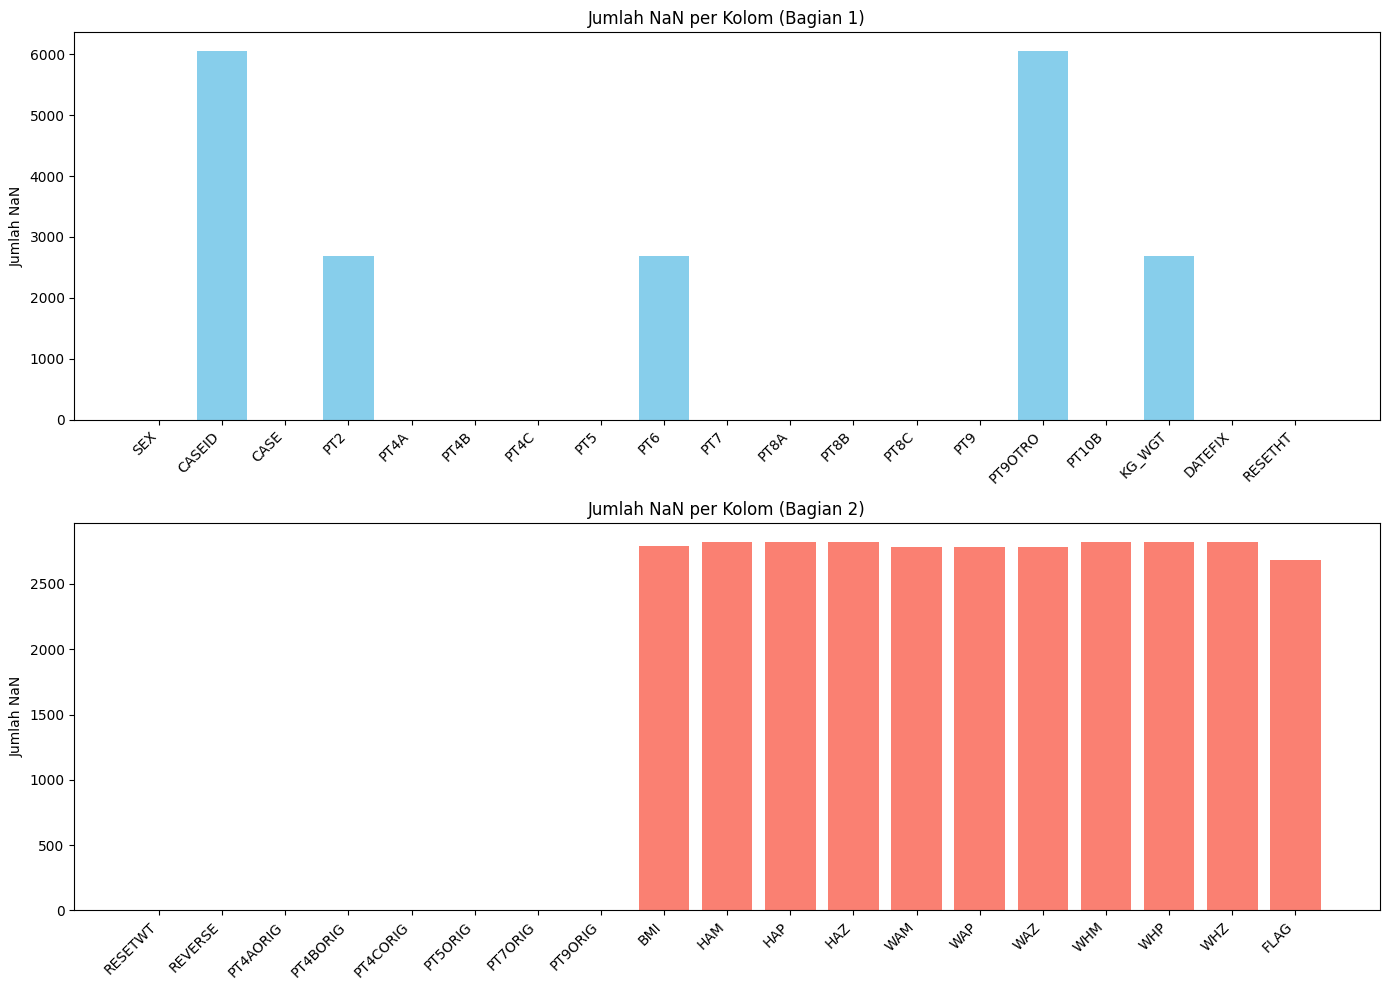

In [ ]:
nan_counts = df.isna().sum()

midpoint = len(nan_counts) // 2
nan_part1 = nan_counts.iloc[:midpoint]
nan_part2 = nan_counts.iloc[midpoint:]

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].bar(nan_part1.index, nan_part1.values, color='skyblue')
axes[0].set_title('Jumlah NaN per Kolom (Bagian 1)')
axes[0].set_ylabel('Jumlah NaN')
axes[0].set_xticks(range(len(nan_part1)))
axes[0].set_xticklabels(nan_part1.index, rotation=45, ha='right')

axes[1].bar(nan_part2.index, nan_part2.values, color='salmon')
axes[1].set_title('Jumlah NaN per Kolom (Bagian 2)')
axes[1].set_ylabel('Jumlah NaN')
axes[1].set_xticks(range(len(nan_part2)))
axes[1].set_xticklabels(nan_part2.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Cek Outlier

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

outlier_info = {}
cols_with_outlier = []
cols_without_outlier = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outlier_info[col] = len(outliers)

    if df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0] > 0:
        cols_with_outlier.append(col)
    else:
        cols_without_outlier.append(col)

outlier_df = pd.DataFrame.from_dict(outlier_info, orient='index', columns=['Jumlah Outlier'])
outlier_df.sort_values(by='Jumlah Outlier', ascending=False)

,Jumlah Outlier
HAP,457
WAP,315
PT4A,263
PT4AORIG,262
WHM,120
PT9ORIG,119
PT5,116
PT7,115
KG_WGT,100
PT8B,95


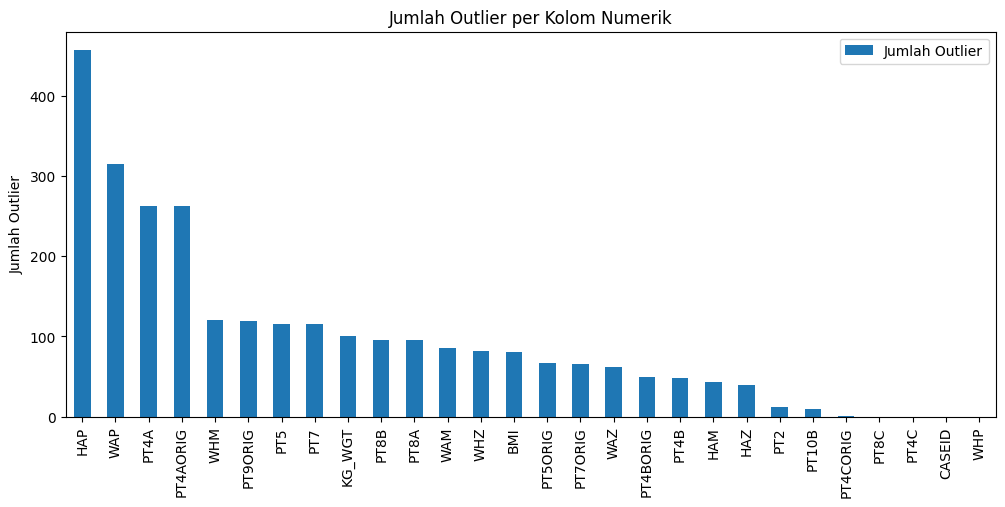

In [ ]:
outlier_df.sort_values(by='Jumlah Outlier', ascending=False).plot(kind='bar', figsize=(12, 5))
plt.title('Jumlah Outlier per Kolom Numerik')
plt.ylabel('Jumlah Outlier')
plt.show()

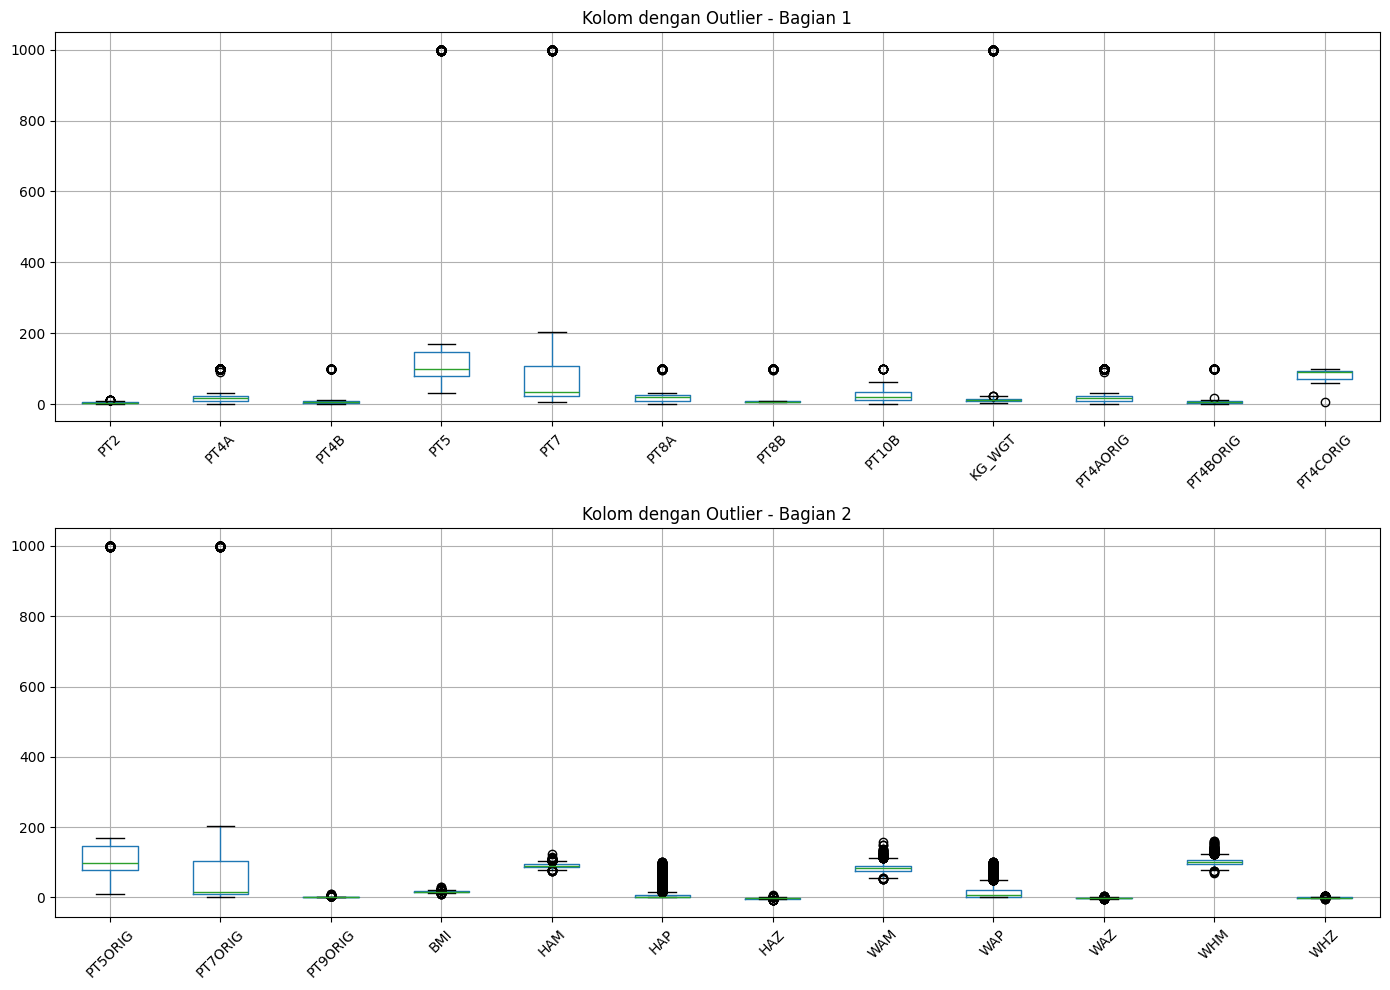

In [ ]:

midpoint = len(cols_with_outlier) // 2
part1 = cols_with_outlier[:midpoint]
part2 = cols_with_outlier[midpoint:]

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

df[part1].boxplot(ax=axes[0])
axes[0].set_title('Kolom dengan Outlier - Bagian 1')
axes[0].tick_params(axis='x', rotation=45)

df[part2].boxplot(ax=axes[1])
axes[1].set_title('Kolom dengan Outlier - Bagian 2')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

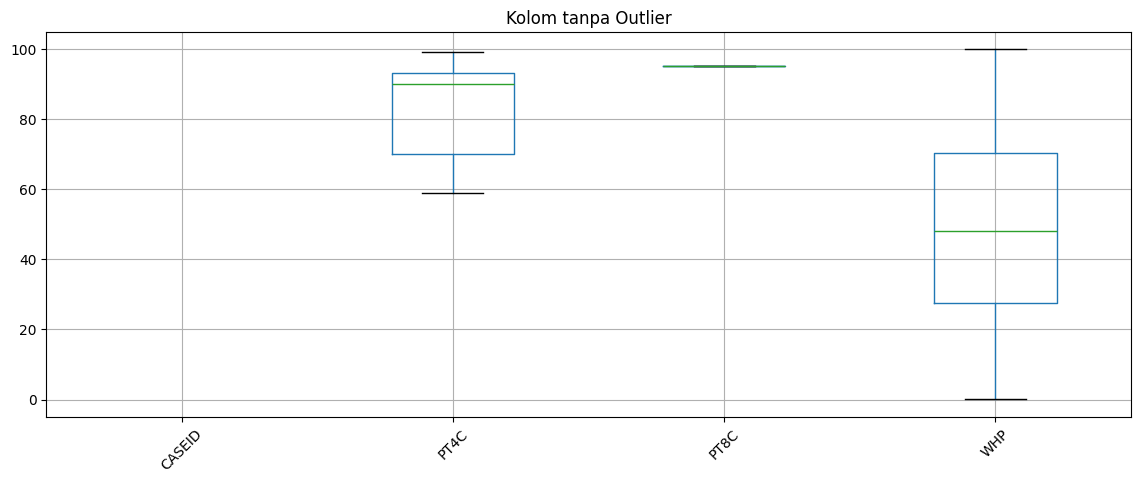

In [ ]:
if cols_without_outlier:
    plt.figure(figsize=(14, 5))
    df[cols_without_outlier].boxplot()
    plt.title('Kolom tanpa Outlier')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Tidak ada kolom tanpa outlier.")

# Feature Engineering

In [ ]:
#Rename Nama Kolom
dg = df.rename(columns={
    'SEX': 'Jenis_Kelamin',
    'PT4A': 'Tanggal_Lahir',
    'PT4B': 'Bulan_Lahir',
    'PT4C': 'Tahun_Lahir',
    'PT5': 'Tinggi_Badan',
    'PT7': 'Berat_Badan',
    'PT8A': 'Tanggal_Ukur',
    'PT8B': 'Bulan_Ukur',
    'PT8C': 'Tahun_Ukur',
})

In [ ]:
df = dg[['Jenis_Kelamin', 'Tanggal_Lahir','Bulan_Lahir','Tahun_Lahir','Tinggi_Badan', 'Berat_Badan', 'Tanggal_Ukur', 'Bulan_Ukur', 'Tahun_Ukur']]

In [ ]:
df.head()

,Jenis_Kelamin,Tanggal_Lahir,Bulan_Lahir,Tahun_Lahir,Tinggi_Badan,Berat_Badan,Tanggal_Ukur,Bulan_Ukur,Tahun_Ukur
0,MALE,27,4,60,155.6,137.0,29,8,95
1,FEMALE,27,10,93,82.7,24.4,29,8,95
2,MALE,99,5,74,148.7,112.0,30,8,95
3,MALE,31,5,90,101.1,38.3,30,8,95
4,MALE,9,1,92,97.2,30.2,30,8,95


In [ ]:
# Ubah berat badan dalam pounds ke kg dengan aman
df.loc[:, 'Berat_Badan'] = (df['Berat_Badan'] * 0.45359237).round(1)

In [ ]:
df.loc[:, 'Tahun_Lahir'] = df['Tahun_Lahir'].apply(lambda x: 1900+x if x > 25 else 2000+x)
df.loc[:, 'Tahun_Ukur'] = df['Tahun_Ukur'].apply(lambda x: 1900+x if x > 25 else 2000+x)

In [ ]:
# Gabungkan Kolom Hari, Bulan, Tahun Lahir dan Ukur untuk menghitung Usia
df.loc[:, 'Lahir'] = (
    df['Tanggal_Lahir'].astype(str).str.zfill(2) + '-' +
    df['Bulan_Lahir'].astype(str).str.zfill(2) + '-' +
    df['Tahun_Lahir'].astype(str)
)

df.loc[:, 'Ukur'] = (
    df['Tanggal_Ukur'].astype(str).str.zfill(2) + '-' +
    df['Bulan_Ukur'].astype(str).str.zfill(2) + '-' +
    df['Tahun_Ukur'].astype(str)
)

In [ ]:
df[["Lahir", "Ukur"]].head()

,Lahir,Ukur
0,27-04-1960,29-08-1995
1,27-10-1993,29-08-1995
2,99-05-1974,30-08-1995
3,31-05-1990,30-08-1995
4,09-01-1992,30-08-1995


In [ ]:
df = df.copy()  # pastikan df bukan view
df.drop(columns=[
    'Tanggal_Lahir','Bulan_Lahir','Tahun_Lahir',
    'Tanggal_Ukur','Bulan_Ukur','Tahun_Ukur'
], inplace=True)

df.head()

,Jenis_Kelamin,Tinggi_Badan,Berat_Badan,Lahir,Ukur
0,MALE,155.6,62.1,27-04-1960,29-08-1995
1,FEMALE,82.7,11.1,27-10-1993,29-08-1995
2,MALE,148.7,50.8,99-05-1974,30-08-1995
3,MALE,101.1,17.4,31-05-1990,30-08-1995
4,MALE,97.2,13.7,09-01-1992,30-08-1995


In [ ]:
#Ubah tipe data lahir dan ukur jadi datetime
df['Lahir'] = pd.to_datetime(df['Lahir'], errors='coerce')
df['Ukur'] = pd.to_datetime(df['Ukur'], errors='coerce')

# Hitung umur dalam bulan
df['Umur_Bulan'] = (df['Ukur'].dt.year - df['Lahir'].dt.year) * 12 + \
                   (df['Ukur'].dt.month - df['Lahir'].dt.month)

/tmp/ipython-input-3934234029.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Lahir'] = pd.to_datetime(df['Lahir'], errors='coerce')
/tmp/ipython-input-3934234029.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Ukur'] = pd.to_datetime(df['Ukur'], errors='coerce')


In [ ]:
df[["Lahir", "Ukur", "Umur_Bulan"]].head()

,Lahir,Ukur,Umur_Bulan
0,1960-04-27,1995-08-29,424.0
1,1993-10-27,1995-08-29,22.0
2,NaT,1995-08-30,NaN
3,1990-05-31,1995-08-30,63.0
4,1992-01-09,1995-08-30,43.0


In [ ]:
df = df.copy()  # pastikan df bukan view
df.drop(columns=[
    'Lahir','Ukur',
], inplace=True)

df.head()

,Jenis_Kelamin,Tinggi_Badan,Berat_Badan,Umur_Bulan
0,MALE,155.6,62.1,424.0
1,FEMALE,82.7,11.1,22.0
2,MALE,148.7,50.8,NaN
3,MALE,101.1,17.4,63.0
4,MALE,97.2,13.7,43.0


In [ ]:
numerical_cols = ['Berat_Badan', 'Tinggi_Badan', 'Umur_Bulan', 'Jenis_Kelamin']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

## Cleaning Nan

In [ ]:
df.isnull().sum()

In [ ]:
df = df.dropna(how="any", subset=['Umur_Bulan'])

In [ ]:
df.isnull().sum()

In [ ]:
sns.heatmap(df.isnull())

## Encode & Mapping Label

In [ ]:
jk_encoder = LabelEncoder()

df["Jenis_Kelamin"] = jk_encoder.fit_transform(df["Jenis_Kelamin"])

jk_mapping = dict(zip(jk_encoder.classes_, range(len(jk_encoder.classes_))))

In [ ]:
print("JK label:", jk_mapping)
print("")
print(df[["Jenis_Kelamin"]].head())

JK label: {'FEMALE': 0, 'MALE': 1}

     Jenis_Kelamin
304              0
305              1
306              0
307              0
308              0


## Delete outlier

In [ ]:
Q1 = df[['Berat_Badan', 'Tinggi_Badan', 'Umur_Bulan', 'Jenis_Kelamin']].quantile(0.25)
Q3 = df[['Berat_Badan', 'Tinggi_Badan', 'Umur_Bulan', 'Jenis_Kelamin']].quantile(0.75)

In [ ]:
IQR = Q3 - Q1
outlierQ3 = Q3 + 1.5 * IQR

In [ ]:
df = df[(df[['Berat_Badan', 'Tinggi_Badan', 'Umur_Bulan', 'Jenis_Kelamin']] < outlierQ3)]
df[['Berat_Badan', 'Tinggi_Badan', 'Umur_Bulan', 'Jenis_Kelamin']].describe()

In [ ]:
numerical_cols = ['Berat_Badan', 'Tinggi_Badan', 'Umur_Bulan', 'Jenis_Kelamin']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

## Delete duplicate

In [ ]:
df.duplicated().sum()

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df_negatif = df[df['Umur_Bulan'] < 0]
print(df_negatif)

In [ ]:
df = df[df['Umur_Bulan'] >= 0]

## Cek Distribusi Class Target

In [ ]:
df.shape

In [ ]:
# def kategori_umur(umur):
#     if umur <= 59:
#         return "0-59 bulan"
#     elif 60 <= umur <= 168:
#         return "5-14 tahun"
#     else:
#         return "15 tahun ke atas"

# df['Kategori_Umur'] = df['Umur_Bulan'].apply(kategori_umur)

# umur_counts = df['Kategori_Umur'].value_counts()

# plt.figure(figsize=(6,6))
# plt.pie(umur_counts, labels=umur_counts.index, autopct='%1.1f%%', startangle=90)
# plt.title('Distribusi Umur')
# plt.axis('equal')
# plt.show()

In [ ]:
def kategori_umur(umur):
    if umur <= 59:
        return "0-59 bulan"
    elif 60 <= umur <= 68:
        return "5 tahun (60-68 bulan)"
    elif 204 <= umur <= 240:
        return "17-20 tahun"
    else:
        return "Lainnya"

df['Kategori_Umur'] = df['Umur_Bulan'].apply(kategori_umur)

df = df[df['Kategori_Umur'] != "Lainnya"]

umur_counts = df['Kategori_Umur'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(umur_counts, labels=umur_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Umur')
plt.axis('equal')
plt.show()


In [ ]:
df.shape

### Create Synthesis Data

In [ ]:
df_0_59 = df[df['Kategori_Umur'] == "0-59 bulan"]
df_5_th = df[df['Kategori_Umur'] == "5 tahun (60-68 bulan)"]
df_17_20 = df[df['Kategori_Umur'] == "17-20 tahun"]

min_size = min(len(df_0_59), len(df_5_th), len(df_17_20))

df_0_59_bal = resample(df_0_59, replace=False, n_samples=min_size, random_state=42)
df_5_th_bal = resample(df_5_th, replace=False, n_samples=min_size, random_state=42)
df_17_20_bal = resample(df_17_20, replace=False, n_samples=min_size, random_state=42)

df_balanced = pd.concat([df_0_59_bal, df_5_th_bal, df_17_20_bal])

umur_counts = df_balanced['Kategori_Umur'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(umur_counts, labels=umur_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Umur (Balanced - Undersampling)')
plt.axis('equal')
plt.show()

In [ ]:
df_balanced.shape

In [ ]:
metadata = Metadata.detect_from_dataframe(
    data=df_balanced)

In [ ]:
synthesizer = CTGANSynthesizer(metadata)

In [ ]:
synthesizer.fit(df_balanced)

In [ ]:
target_rows = 8000
rows_to_add = target_rows - df.shape[0]

synthetic_data = synthesizer.sample(rows_to_add)

In [ ]:
diagnostic_report = run_diagnostic(
    real_data=df_balanced,
    synthetic_data=synthetic_data,
    metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 5/5 [00:00<00:00, 704.33it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 233.30it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [ ]:
quality_report = evaluate_quality(
    real_data=df_balanced,
    synthetic_data=synthetic_data,
    metadata=metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 5/5 [00:00<00:00, 100.41it/s]|
Column Shapes Score: 85.56%

(2/2) Evaluating Column Pair Trends: |██████████| 10/10 [00:00<00:00, 138.04it/s]|
Column Pair Trends Score: 58.04%

Overall Score (Average): 71.8%



In [ ]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,Jenis_Kelamin,TVComplement,0.967601
1,Tinggi_Badan,KSComplement,0.865131
2,Berat_Badan,KSComplement,0.689407
3,Umur_Bulan,KSComplement,0.779624
4,Kategori_Umur,TVComplement,0.976483


In [ ]:
fig = get_column_plot(
    real_data=df_balanced,
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_name='Jenis_Kelamin'
)

fig.show()

In [ ]:
fig = get_column_plot(
    real_data=df_balanced,
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_name='Tinggi_Badan'
)

fig.show()

In [ ]:
df_augmented = pd.concat([df_balanced, synthetic_data], ignore_index=True)

print("Data asli:", df.shape)
print("Data augmented:", df_augmented.shape)

Data asli: (3606, 5)
Data augmented: (5306, 5)


In [ ]:
def kategori_umur(umur):
    if umur <= 59:
        return "0-59 bulan"
    elif 60 <= umur <= 68:
        return "5 tahun (60-68 bulan)"
    elif 204 <= umur <= 240:
        return "17-20 tahun"
    else:
        return "Lainnya"

df_augmented['Kategori_Umur'] = df_augmented['Umur_Bulan'].apply(kategori_umur)

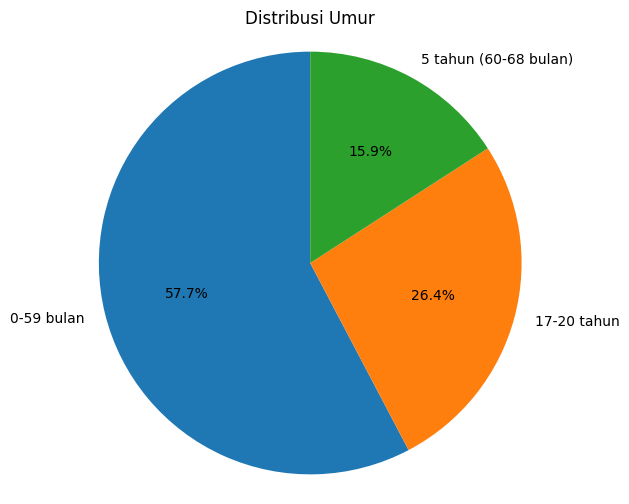

In [ ]:
df_augmented = df_augmented[df_augmented['Kategori_Umur'] != "Lainnya"]

umur_counts = df_augmented['Kategori_Umur'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(umur_counts, labels=umur_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Umur')
plt.axis('equal')
plt.show()

In [ ]:
df_augmented.shape

(4743, 5)

In [ ]:
df = df_augmented

In [ ]:
#ambil data hanya 60 bulan ke atas (5 tahun ke atas)
df = df[df['Umur_Bulan'] >= 60]

In [ ]:
df.shape

(2006, 5)

In [ ]:
df.head()

,Jenis_Kelamin,Tinggi_Badan,Berat_Badan,Umur_Bulan,Kategori_Umur
304,0,100.6,16.0,62.0,5 tahun (60-68 bulan)
305,1,102.0,15.5,64.0,5 tahun (60-68 bulan)
306,0,93.0,13.2,62.0,5 tahun (60-68 bulan)
307,0,88.0,13.9,62.0,5 tahun (60-68 bulan)
308,0,102.4,15.9,63.0,5 tahun (60-68 bulan)


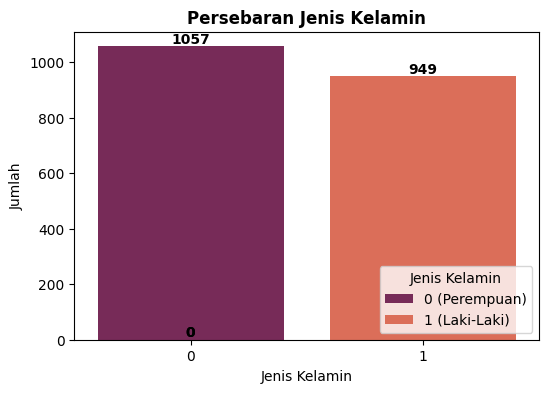

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x="Jenis_Kelamin", hue="Jenis_Kelamin", data=df, palette="rocket")

for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=10, fontweight='bold'
    )

plt.title("Persebaran Jenis Kelamin", fontsize=12, fontweight='bold')
plt.xlabel("Jenis Kelamin", fontsize=10)
plt.ylabel("Jumlah", fontsize=10)
plt.legend(title="Jenis Kelamin", labels=["0 (Perempuan)", "1 (Laki-Laki)"])

plt.show()

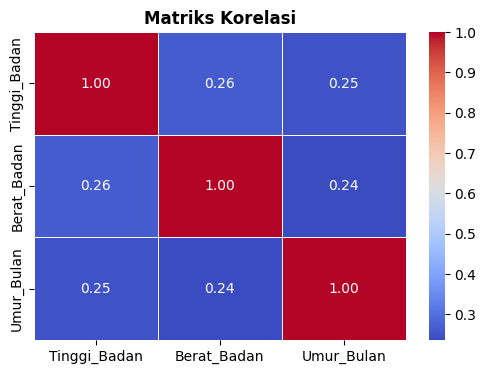

In [ ]:
numeric_cols = ['Tinggi_Badan', 'Berat_Badan', 'Umur_Bulan']
correlation = df[numeric_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Matriks Korelasi", fontsize=12, fontweight='bold')
plt.show()

In [ ]:
#Data L,M,S WHO (5-14 tahun)
lms_lk = pd.read_excel("laki_laki.xlsx")
lms_pr = pd.read_excel("perempuan.xlsx")

lms_lk.rename(columns={"Month": "Umur_Bulan"}, inplace=True)
lms_pr.rename(columns={"Month": "Umur_Bulan"}, inplace=True)

# Pastikan Umur_Bulan integer
lms_lk['Umur_Bulan'] = lms_lk['Umur_Bulan'].astype(int)
lms_pr['Umur_Bulan'] = lms_pr['Umur_Bulan'].astype(int)

In [ ]:
#Menghitung BMI
df['BMI'] = df['Berat_Badan'] / ( (df['Tinggi_Badan'] / 100) ** 2 )

In [ ]:
def hitung_baz(bmi, L, M, S):
    if pd.isna(L) or pd.isna(M) or pd.isna(S):
        return np.nan
    if L != 0:
        return ((bmi / M) ** L - 1) / (L * S)
    else:
        return np.log(bmi / M) / S

In [ ]:
L_list, M_list, S_list = [], [], []

for idx, row in df.iterrows():
    if row['Jenis_Kelamin'] == 1:  # 1 = laki-laki
        lms_row = lms_lk[lms_lk['Umur_Bulan'] == row['Umur_Bulan']]
    elif row['Jenis_Kelamin'] == 0:  # 0 = perempuan
        lms_row = lms_pr[lms_pr['Umur_Bulan'] == row['Umur_Bulan']]
    else:
        lms_row = pd.DataFrame()

    if not lms_row.empty:
        L_list.append(lms_row['L'].values[0])
        M_list.append(lms_row['M'].values[0])
        S_list.append(lms_row['S'].values[0])
    else:
        L_list.append(np.nan)
        M_list.append(np.nan)
        S_list.append(np.nan)

df['L'] = L_list
df['M'] = M_list
df['S'] = S_list

In [ ]:
df['BAZ'] = df.apply(
    lambda row: hitung_baz(row['BMI'], row['L'], row['M'], row['S'])
                if 61 <= row['Umur_Bulan'] <= 168 else np.nan,
    axis=1
)

In [ ]:
def calc_baz(bmi, L, M, S):
    if L == 0:
        return math.log(bmi / M) / S
    else:
        return ((bmi / M) ** L - 1) / (L * S)

In [ ]:
def hitung_baz(bmi, umur_bulan, jk):
    if jk == 1:  # laki-laki
        lms = lms_lk
    else:
        lms = lms_pr

    row = lms[lms['Umur_Bulan'] == umur_bulan]
    if row.empty:
        return None

    L = row['L'].values[0]
    M = row['M'].values[0]
    S = row['S'].values[0]

    if L != 0:
        baz = ((bmi / M) ** L - 1) / (L * S)
    else:
        baz = (np.log(bmi / M)) / S
    return baz

def klasifikasi_status(umur_bulan, bmi, baz):
    if 60 <= umur_bulan <= 168:  # 5 - 14 tahun
        if baz is None:
            return "Data LMS tidak tersedia"
        if -3 <= baz < -2:
            return "Kurus"
        elif -2 <= baz <= 1:
            return "Normal"
        elif 1 < baz <= 2:
            return "Berat Badan Lebih"
        elif baz > 2:
            return "Obesitas"
        else:
            return "Di luar kategori tabel"
    elif umur_bulan > 168:  # > 14 tahun
        if bmi < 18.5:
            return "Kurus"
        elif 18.5 <= bmi < 22.9:
            return "Normal"
        elif 23 <= bmi < 27.4:
            return "Berat Badan Lebih"
        elif bmi >= 27.5:
            return "Obesitas"
        else:
            return "Di luar kategori tabel"
    else:
        return "Umur < 5 tahun — BAZ tidak dihitung"

df["BMI"] = df["Berat_Badan"] / ((df["Tinggi_Badan"] / 100) ** 2)

df["BAZ"] = df.apply(
    lambda row: hitung_baz(row["BMI"], row["Umur_Bulan"], row["Jenis_Kelamin"])
    if 60 <= row["Umur_Bulan"] <= 168 else None, axis=1
)

df["Status_Gizi"] = df.apply(
    lambda row: klasifikasi_status(row["Umur_Bulan"], row["BMI"], row["BAZ"]), axis=1
)

In [ ]:
df["Status_Gizi"].head()

,Status_Gizi
304,Normal
305,Normal
306,Normal
307,Berat Badan Lebih
308,Normal


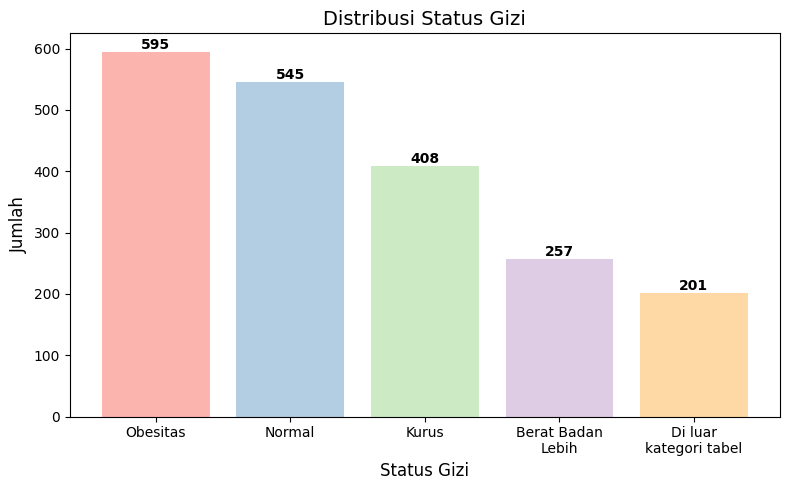

In [ ]:
counts = df['Status_Gizi'].value_counts()

labels = [textwrap.fill(label, 15) for label in counts.keys()]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts.values, color=plt.cm.Pastel1.colors)

plt.title('Distribusi Status Gizi', fontsize=14)
plt.xlabel('Status Gizi', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=0, ha='center')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()


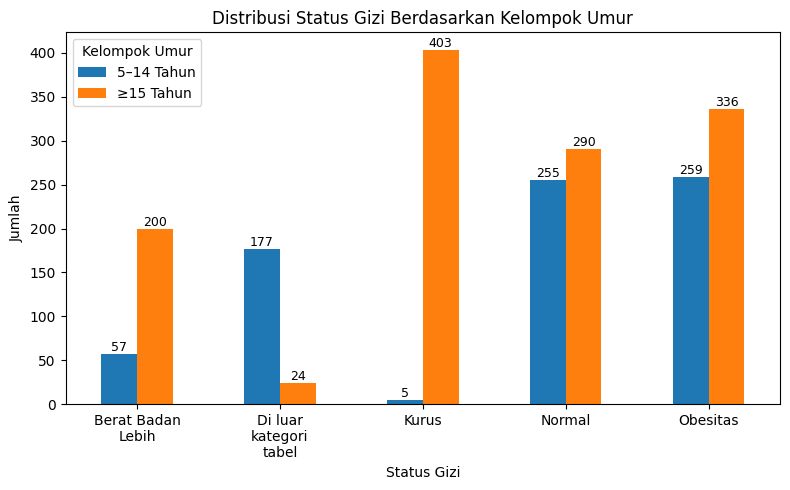

In [ ]:
df_5_14 = df[(df["Umur_Bulan"] >= 60) & (df["Umur_Bulan"] <= 168)]
df_15_up = df[df["Umur_Bulan"] > 168]

dist_5_14 = df_5_14["Status_Gizi"].value_counts()
dist_15_up = df_15_up["Status_Gizi"].value_counts()

dist_df = pd.DataFrame({
    "5–14 Tahun": dist_5_14,
    "≥15 Tahun": dist_15_up
}).fillna(0).astype(int)

dist_df.index = [textwrap.fill(label, width=12) for label in dist_df.index]

ax = dist_df.plot(kind="bar", figsize=(8,5))
plt.title("Distribusi Status Gizi Berdasarkan Kelompok Umur")
plt.ylabel("Jumlah")
plt.xlabel("Status Gizi")
plt.xticks(rotation=0)
plt.legend(title="Kelompok Umur")

for p in ax.patches:
    ax.annotate(str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Simpan hasil
df.to_csv("hasil_klasifikasi.csv", index=False)

print("Proses selesai! File hasil tersimpan sebagai 'hasil_klasifikasi.csv'")

Proses selesai! File hasil tersimpan sebagai 'hasil_klasifikasi.csv'


In [ ]:
df["Umur_Tahun"] = (df["Umur_Bulan"] / 12).astype(int)

# Feature Selection

In [ ]:
#Memilih kolom yg akan digunakan
df_model = df[['Jenis_Kelamin', 'Tinggi_Badan', 'Berat_Badan', 'Umur_Bulan', 'Umur_Tahun', 'BMI', 'BAZ', 'Status_Gizi']]

In [ ]:
df_model.head()

,Jenis_Kelamin,Tinggi_Badan,Berat_Badan,Umur_Bulan,Umur_Tahun,BMI,BAZ,Status_Gizi
304,0,100.6,16.0,62.0,5,15.809714,0.368466,Normal
305,1,102.0,15.5,64.0,5,14.898116,-0.286722,Normal
306,0,93.0,13.2,62.0,5,15.261880,0.012435,Normal
307,0,88.0,13.9,62.0,5,17.949380,1.559648,Berat Badan Lebih
308,0,102.4,15.9,63.0,5,15.163422,-0.053836,Normal


In [ ]:
df_model.isnull().sum()

,0
Jenis_Kelamin,0
Tinggi_Badan,15
Berat_Badan,8
Umur_Bulan,0
Umur_Tahun,0
BMI,21
BAZ,1356
Status_Gizi,0


In [ ]:
df_model.shape

(2006, 8)

In [ ]:
df_model = df_model.dropna(subset=['Tinggi_Badan', 'Berat_Badan', 'BMI'])
df_model["BAZ"] = df_model["BAZ"].fillna(0)

In [ ]:
df_model.isnull().sum()

,0
Jenis_Kelamin,0
Tinggi_Badan,0
Berat_Badan,0
Umur_Bulan,0
Umur_Tahun,0
BMI,0
BAZ,0
Status_Gizi,0


In [ ]:
df_model.shape

(1985, 8)

In [ ]:
label_encoder = LabelEncoder()
df_model['Status_Gizi'] = label_encoder.fit_transform(df_model['Status_Gizi'])

In [ ]:
label_encoder.classes_

array(['Berat Badan Lebih', 'Di luar kategori tabel', 'Kurus', 'Normal',
       'Obesitas'], dtype=object)

In [ ]:
df_model.head()

,Jenis_Kelamin,Tinggi_Badan,Berat_Badan,Umur_Bulan,Umur_Tahun,BMI,BAZ,Status_Gizi
304,0,100.6,16.0,62.0,5,15.809714,0.368466,3
305,1,102.0,15.5,64.0,5,14.898116,-0.286722,3
306,0,93.0,13.2,62.0,5,15.261880,0.012435,3
307,0,88.0,13.9,62.0,5,17.949380,1.559648,0
308,0,102.4,15.9,63.0,5,15.163422,-0.053836,3


# Split Dataset

In [ ]:
X = df_model.drop(columns = ['Status_Gizi'])
y = df_model['Status_Gizi']

print("X : ", X.shape)
print("y :", y.shape)

X :  (1985, 7)
y : (1985,)


In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.176, random_state=42)

print(f"Train: {len(X_train)} data")
print(f"Valid: {len(X_val)} data")
print(f"Test : {len(X_test)} data")

Train: 1390 data
Valid: 297 data
Test : 298 data


# Normalisasi Data

In [ ]:
# Decision Tree tidak pakai scaler karena Pohon hanya membandingkan nilai fitur dengan threshold

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Oversampling

In [ ]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# print("Distribusi sebelum ROS:\n", y_train.value_counts())
# print("\nDistribusi sesudah ROS:\n", y_train_res.value_counts())

In [ ]:
# sm = RandomOverSampler(random_state=42)
# X_res, y_res = sm.fit_resample(X, y)

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribusi sebelum SMOTE:\n", y_train.value_counts())
print("\nDistribusi sesudah SMOTE:\n", y_train_res.value_counts())

Distribusi sebelum SMOTE:
 Status_Gizi
4    419
3    366
2    295
0    190
1    120
Name: count, dtype: int64

Distribusi sesudah SMOTE:
 Status_Gizi
2    419
1    419
4    419
3    419
0    419
Name: count, dtype: int64


In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

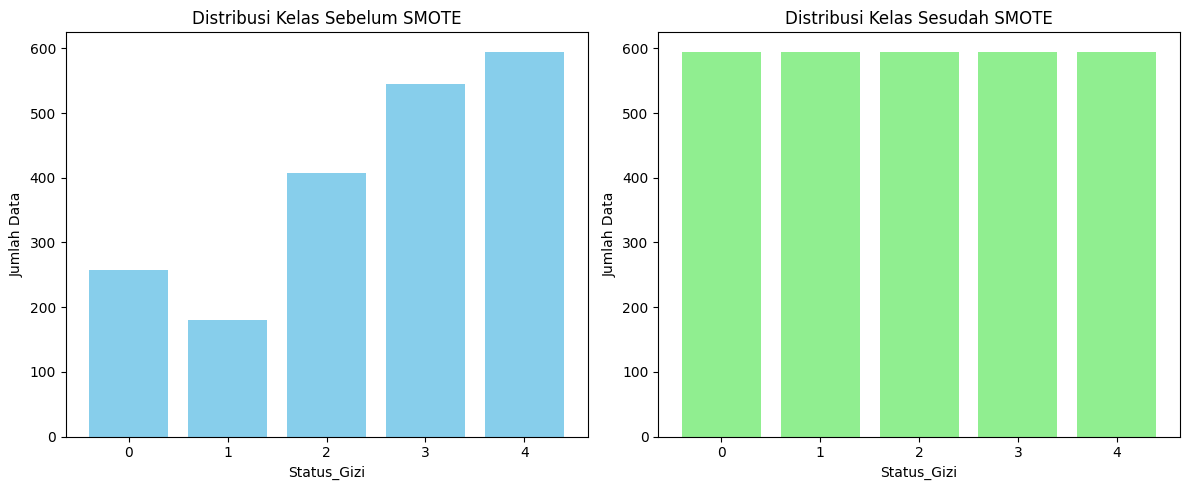

In [ ]:
from collections import Counter

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].bar(Counter(y).keys(), Counter(y).values(), color='skyblue')
axes[0].set_title("Distribusi Kelas Sebelum SMOTE")
axes[0].set_xlabel("Status_Gizi")
axes[0].set_ylabel("Jumlah Data")

axes[1].bar(Counter(y_res).keys(), Counter(y_res).values(), color='lightgreen')
axes[1].set_title("Distribusi Kelas Sesudah SMOTE")
axes[1].set_xlabel("Status_Gizi")
axes[1].set_ylabel("Jumlah Data")

plt.tight_layout()
plt.show()

# Modeling

In [ ]:
k_values = range(1, 21)
metrics_result = {'k': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

In [ ]:
for k in k_values:
    dt = KNeighborsClassifier(
        n_neighbors=k,
        metric='euclidean'
    )
    dt.fit(X_train_res, y_train_res)
    y_pred = dt.predict(X_val)

    metrics_result['k'].append(k)
    metrics_result['accuracy'].append(accuracy_score(y_val, y_pred))
    metrics_result['precision'].append(precision_score(y_val, y_pred, average='weighted', zero_division=0))
    metrics_result['recall'].append(recall_score(y_val, y_pred, average='weighted', zero_division=0))
    metrics_result['f1'].append(f1_score(y_val, y_pred, average='weighted', zero_division=0))

metrics_df = pd.DataFrame(metrics_result)

In [ ]:
print("\nHasil evaluasi di Validation set:\n\n", metrics_df)


Hasil evaluasi di Validation set:

      k  accuracy  precision    recall        f1
0    1  0.898990   0.904878  0.898990  0.900171
1    2  0.865320   0.889436  0.865320  0.867629
2    3  0.878788   0.893723  0.878788  0.880893
3    4  0.858586   0.885275  0.858586  0.860949
4    5  0.851852   0.875330  0.851852  0.854298
5    6  0.848485   0.874067  0.848485  0.850949
6    7  0.851852   0.869936  0.851852  0.855465
7    8  0.845118   0.867695  0.845118  0.846923
8    9  0.848485   0.869091  0.848485  0.850178
9   10  0.848485   0.873567  0.848485  0.850146
10  11  0.858586   0.877818  0.858586  0.861068
11  12  0.868687   0.889129  0.868687  0.871375
12  13  0.858586   0.876706  0.858586  0.862253
13  14  0.845118   0.866547  0.845118  0.848676
14  15  0.845118   0.866547  0.845118  0.848676
15  16  0.831650   0.857362  0.831650  0.836014
16  17  0.838384   0.864407  0.838384  0.843400
17  18  0.835017   0.861126  0.835017  0.839560
18  19  0.841751   0.863911  0.841751  0.846187
19 

# Evaluasi

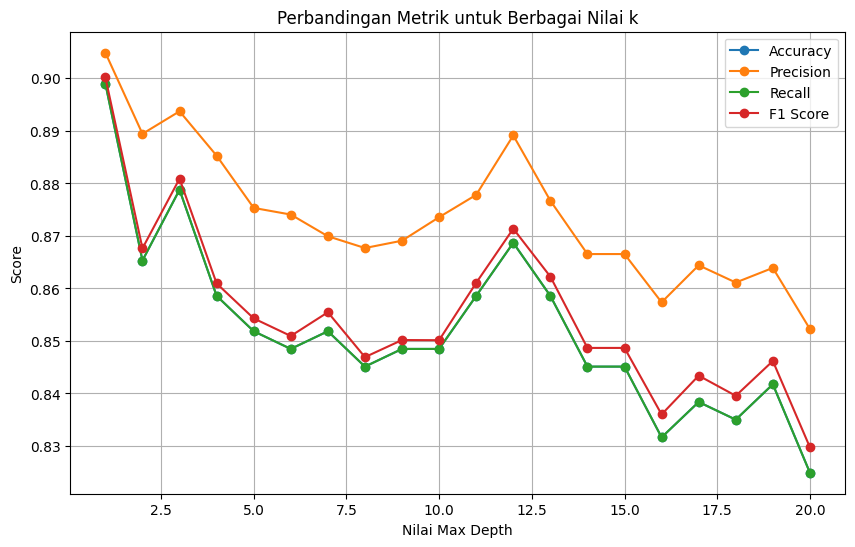

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['k'], metrics_df['accuracy'], marker='o', label='Accuracy')
plt.plot(metrics_df['k'], metrics_df['precision'], marker='o', label='Precision')
plt.plot(metrics_df['k'], metrics_df['recall'], marker='o', label='Recall')
plt.plot(metrics_df['k'], metrics_df['f1'], marker='o', label='F1 Score')
plt.xlabel('Nilai Max Depth')
plt.ylabel('Score')
plt.title('Perbandingan Metrik untuk Berbagai Nilai k')
plt.legend()
plt.grid(True)
plt.show()

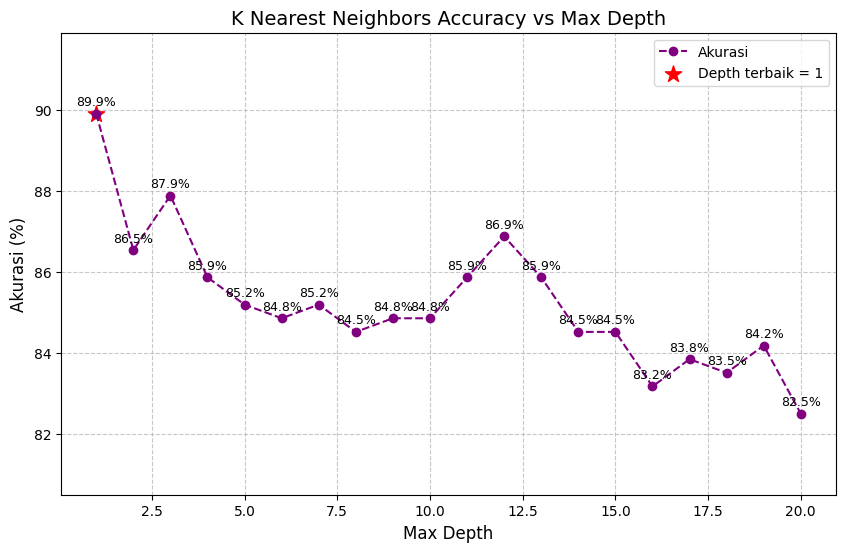

In [ ]:
depth_values = metrics_result["k"]
accuracy_values = metrics_result["accuracy"]

accuracy_percent = [acc * 100 for acc in accuracy_values]

best_idx = np.argmax(accuracy_percent)
best_depth = depth_values[best_idx]
best_acc = accuracy_percent[best_idx]

plt.figure(figsize=(10,6))
plt.plot(depth_values, accuracy_percent, marker='o', linestyle='--', color='purple', label='Akurasi')

plt.scatter(best_depth, best_acc, color='red', s=150, marker='*', label=f'Depth terbaik = {best_depth}')

for i, acc in enumerate(accuracy_percent):
    plt.text(depth_values[i], acc+0.2, f"{acc:.1f}%", ha='center', fontsize=9)

plt.title("K Nearest Neighbors Accuracy vs Max Depth", fontsize=14)
plt.xlabel("Max Depth", fontsize=12)
plt.ylabel("Akurasi (%)", fontsize=12)
plt.ylim(min(accuracy_percent)-2, max(accuracy_percent)+2)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

In [ ]:
best_max_depth = metrics_df.loc[metrics_df['f1'].idxmax(), 'k']
print(f"Best Depth Max: {best_max_depth}")

Best Depth Max: 1


In [ ]:
final_model = KNeighborsClassifier(
    n_neighbors=3, # best_max_depth
    metric='euclidean'
  )

final_model.fit(X_train_res, y_train_res)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [ ]:
y_pred_test = final_model.predict(X_test)

In [ ]:
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, y_pred_test))


Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.61      0.88      0.72        34
           1       0.78      0.88      0.83        33
           2       0.96      0.98      0.97        52
           3       0.95      0.80      0.87        96
           4       0.97      0.92      0.94        83

    accuracy                           0.88       298
   macro avg       0.86      0.89      0.87       298
weighted avg       0.90      0.88      0.89       298



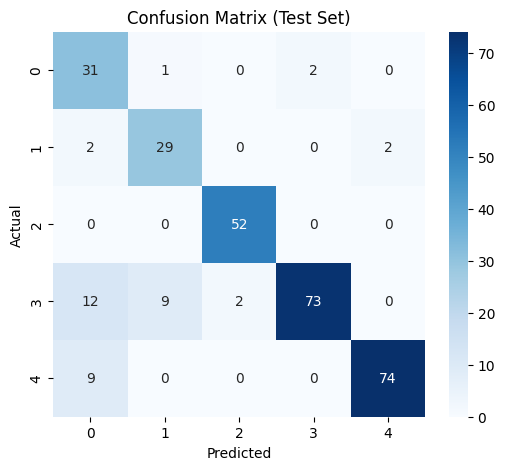

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
joblib.dump(final_model, 'model.h5')
print("Model saved as model.h5")

Model saved as model.h5


In [ ]:
joblib.dump(scaler, 'scaler.pkl')
print("Model saved as scaler.pkl")

Model saved as scaler.pkl


## Hyperparameter Tuning

In [ ]:
param_grid = {
    'n_neighbors': range(1, 11),  # K dari 1-10
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()

scorer = make_scorer(f1_score, average='weighted', zero_division=0)

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

y_pred = best_knn.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'n_neighbors': 3, 'weights': 'distance'}
Best F1 Score (CV): 0.9100685301589359


In [ ]:
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, y_pred))


Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.64      0.85      0.73        34
           1       0.89      0.76      0.82        33
           2       0.96      1.00      0.98        52
           3       0.92      0.86      0.89        96
           4       0.96      0.94      0.95        83

    accuracy                           0.90       298
   macro avg       0.88      0.88      0.88       298
weighted avg       0.91      0.90      0.90       298



In [ ]:
joblib.dump(best_knn, 'tuning_knn.h5')
print("Model saved as tuning_knn.h5")

Model saved as tuning_knn.h5


# Test Data

In [ ]:
loaded_model = joblib.load('tuning_knn.h5')
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
sample_pred = loaded_model.predict(X_test)
print("Prediction from loaded model matches:", np.array_equal(sample_pred, y_pred_test))

Prediction from loaded model matches: False


In [ ]:
# class DummyModel:
#     def predict(self, X):
#         preds = []
#         for _, row in X.iterrows():
#             if row["Umur_Bulan"] > 168:
#                 if row["BMI"] < 18.5:
#                     preds.append("Kurus")
#                 elif 18.5 <= row["BMI"] < 24.9:
#                     preds.append("Normal")
#                 elif 25 <= row["BMI"] < 29.9:
#                     preds.append("Berat Badan Lebih")
#                 else:
#                     preds.append("Obesitas")
#             else:
#                 baz = row.get("BAZ", None)
#                 if baz is None:
#                     preds.append("Data LMS tidak tersedia")
#                 elif -3 <= baz < -2:
#                     preds.append("Kurus")
#                 elif -2 <= baz <= 1:
#                     preds.append("Normal")
#                 elif 1 < baz <= 2:
#                     preds.append("Berat Badan Lebih")
#                 elif baz > 2:
#                     preds.append("Obesitas")
#                 else:
#                     preds.append("Di luar kategori tabel")
#         return np.array(preds)

# loaded_model = DummyModel()

In [ ]:
data_uji = pd.DataFrame([
    {   # >14 tahun, Kurus
        "Jenis_Kelamin": 1,
        "Tinggi_Badan": 170,
        "Berat_Badan": 50,
        "Umur_Bulan": 192,   # 16 tahun
        "Umur_Tahun": 16,
        "BMI": 50 / ((170/100)**2),  # ~17.3
        "BAZ": 0
    },
    {   # >14 tahun, Normal
        "Jenis_Kelamin": 0,
        "Tinggi_Badan": 165,
        "Berat_Badan": 60,
        "Umur_Bulan": 204,   # 17 tahun
        "Umur_Tahun": 17,
        "BMI": 60 / ((165/100)**2),  # ~22.0
        "BAZ": 0
    },
    {   # <14 tahun, Normal
        "Jenis_Kelamin": 1,
        "Tinggi_Badan": 135,
        "Berat_Badan": 30,
        "Umur_Bulan": 120,   # 10 tahun
        "Umur_Tahun": 10,
        "BMI": 30 / ((135/100)**2),  # ~16.5
        "BAZ": 0.5
    },
    {   # <14 tahun, Obesitas
        "Jenis_Kelamin": 0,
        "Tinggi_Badan": 140,
        "Berat_Badan": 50,
        "Umur_Bulan": 132,   # 11 tahun
        "Umur_Tahun": 11,
        "BMI": 50 / ((140/100)**2),  # ~25.5
        "BAZ": 2.5
    }
])

In [ ]:
prediksi = loaded_model.predict(data_uji)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



In [ ]:
print(prediksi)

[4 4 4 4]


In [ ]:
data_uji["Status_Gizi"] = prediksi

data_uji[["Jenis_Kelamin","Tinggi_Badan","Berat_Badan","Umur_Tahun","BMI","BAZ","Status_Gizi"]]